# Coding session: PyTorch

You are asked to build a classifier that solves XOR classification problem from the lecture.

The classifier should have one hyperparameter $N$ -- the size of hidden layer.

It should have the following layers:
- $L_1(x) = \mathrm{relu}(W_1 x + b_1)$, where $W_1$ has $N$ rows and 2 columns, $b_1$ has $N$ components.
- $L_2(x) = \mathrm{relu}(W_2 x + b_2)$, where $W_2$ has $N$ rows and $N$ columns, $b_1$ has $N$ components.
- $L_3(x) = \mathrm{softmax}(W_3 x + b_3)$, where $W_2$ has $2$ rows and $N$ columns, $b_1$ has $2$ components.

So, the parameters are $W_1, b_1, W_2, b_2, W_3, b_3$. For the input vector $x$, computations should be the following:
- $A = W_1 x + b_1$.
- $B = \mathrm{relu}(A)$
- $C = W_2 B + b_2$
- $D = \mathrm{relu}(C)$
- $E = W_3 D + b_3$
- $F = \mathrm{softmax}(E)$
- return $F$

Helper functions for you:
- `generate_data()`. Returns points ($(x, y)$ pairs) and labels (0 or 1) for XOR problem.
- `visualize_clf(clf, points)`. Applies PyTorch classifier to points generated by `generate_data()`.

In [0]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

def generate_data(xmin=-15, xmax=15, ymin=-15, ymax=15):
    points = []
    labels = []
    for x in range(-15, 15):
        for y in range(-15, 15):
            points.append((float(x), float(y)))
            labels.append(int(x * y < 0))
    return points, labels

def visualize_clf(clf, points):
    import matplotlib.pyplot as plt
    plt.axis('equal')
    X = []
    Y = []
    C = []
    for p in points:
        x, y = p
        r, g, b, a = 0, 0, 0, 0
        result = clf.forward(torch.tensor([x, y]))
        prob_1 = result[1].item()
        if prob_1 > 0.5:
            b = 1
        else:
            r = 1
        a = max(prob_1, 1 - prob_1)
        X.append(x)
        Y.append(y)
        C.append((r, g, b, a))
    plt.scatter(X, Y, c=C)
    plt.show()

## Exercise 1

Implement the class `XORSolver` according to the description of the coding session.

In [0]:
import torch
from torch import nn


class XORSolver(nn.Module):
    def __init__(self, N=10):
        super().__init__()
        torch.manual_seed(0)
        # YOUR CODE HERE
        # define the parameters W1, b1, W2, b2, W3, b3
        # initialize randomly
        self.W1 = nn.Parameter(torch.rand(N, 2) - 0.5)
        self.b1 = nn.Parameter(torch.rand(N) - 0.5)
        self.W2 = nn.Parameter(torch.rand(N, N) - 0.5)
        self.b2 = nn.Parameter(torch.rand(N) - 0.5)
        self.W3 = nn.Parameter(torch.rand(2, N) - 0.5)
        self.b3 = nn.Parameter(torch.rand(2) - 0.5)

    def forward(self, xy):
        # YOUR CODE HERE
        # input is a 1-dimensional tensor: xy[0] is x, xy[1] is y
        # implement the computations according to the description:
        # linear -> relu -> linear-> relu -> linear -> softmax
        # compute softmax with additional argument dim=0
        nonlinearity_1 = torch.relu(torch.matmul(self.W1, xy) + self.b1)
        nonlinearity_2 = torch.relu(torch.matmul(self.W2, nonlinearity_1) + self.b2)
        nonlinearity_3 = torch.relu(torch.matmul(self.W3, nonlinearity_2) + self.b3)
        output = torch.softmax(nonlinearity_3, dim=0)
        return output

## Exercise 2
Create the `XORSolver` with $N=10$ and visualize its predictions using the function `visualize_clf`. It accepts two arguments: the classifier and the set of points (it doesn't accept true labels).

`points` and `labels` are already created for you.

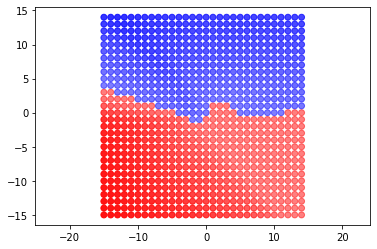

In [59]:
points, labels = generate_data()
N = 10

# YOUR CODE HERE
solver = XORSolver(N)
visualize_clf(solver, points)

## Exercise 3

- Complete the implementation of function `train_clf` that trains the classifier.
- Train the classifier from the previous exercises.
- Visualize the resulting classifier. Does it solve the XOR problem?

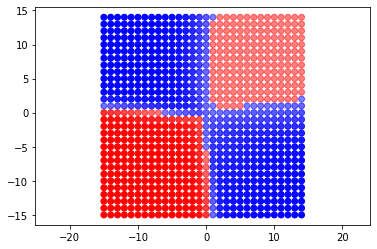

In [60]:
def train_clf(clf, points, labels, num_iterations, learning_rate, seed=0):
    np.random.seed(seed)
    # note that we are using CrossEntropyLoss for classification 
    loss_function = nn.CrossEntropyLoss()

    for t in tqdm(range(num_iterations)):
        lr = learning_rate / np.sqrt(t + 1)

        # here we pick a random training sample
        idx = np.random.choice(range(len(points)))
        x, y = points[idx]
        label = labels[idx]

        # `label` is a number
        # you need to convert it into a one-dimensional tensor `target`
        # this is because CrossEntropyLoss accepts a vector of targets
        ## need to pass label as list else it'll be 0 dim
        target = torch.tensor([label])  # YOUR CODE HERE

        # compute the prediction
        # you need to convert it into 2-dimensional matrix with one row!
        # this is because CrossEntropyLoss accepts a matrix of predictions
        # you can do it using the `unsqueeze()` method
        ## you need to pass x, y as a list to tensor
        ## and pass tensor to clf which has to be unaqueezed
        prediction = clf(torch.tensor([x, y])).unsqueeze(0) # YOUR CODE HERE

        loss = loss_function(prediction, target)
        clf.zero_grad()
        loss.backward()

        with torch.no_grad():
            # update the parameters
            # `lr` is the learning rate
            for parameter in clf.parameters():
                # YOUR CODE HERE
                parameter -= lr * parameter.grad

# YOUR CODE HERE: train the XORSolver using train_clf
num_iterations = 10000
learning_rate = 0.05
train_clf(solver, points, labels, num_iterations, learning_rate)
# YOUR CODE HERE: visualize the result
visualize_clf(solver, points)

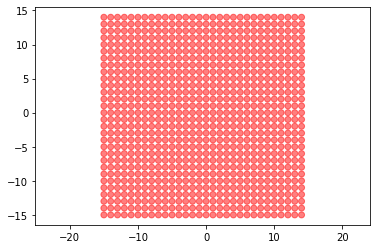

In [78]:
def train_clf_adam(clf, points, labels, num_iterations, learning_rate, seed=0):
    np.random.seed(seed)
    # note that we are using CrossEntropyLoss for classification 
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=learning_rate)

    for t in tqdm(range(num_iterations)):
        lr = learning_rate / np.sqrt(t + 1)

        # here we pick a random training sample
        idx = np.random.choice(range(len(points)))
        x, y = points[idx]
        label = labels[idx]

        # `label` is a number
        # you need to convert it into a one-dimensional tensor `target`
        # this is because CrossEntropyLoss accepts a vector of targets
        target = torch.tensor([label])  # YOUR CODE HERE

        # compute the prediction
        # you need to convert it into 2-dimensional matrix with one row!
        # this is because CrossEntropyLoss accepts a matrix of predictions
        # you can do it using the `unsqueeze()` method
        prediction = clf(torch.tensor([x, y])).unsqueeze(0) # YOUR CODE HERE

        loss = loss_function(prediction, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# YOUR CODE HERE: train the XORSolver using train_clf
num_iterations = 10000
learning_rate = 0.05
train_clf_adam(solver, points, labels, num_iterations, learning_rate)
# YOUR CODE HERE: visualize the result
visualize_clf(solver, points)

## Exercise 4.

Implement the XOR classifier using `nn.Sequential`.
Train and visualize the result (like in the Exercise 3).

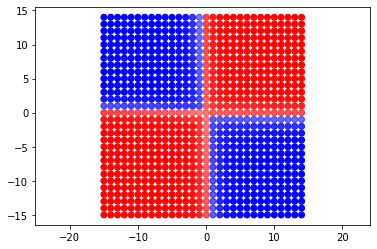

In [76]:
clf2 = nn.Sequential(
    # YOUR CODE HERE
    nn.Linear(2, N),
    nn.ReLU(),
    nn.Linear(N, N),
    nn.ReLU(),
    nn.Linear(N, 2),
    nn.Softmax(dim=0)
)

# YOUR CODE HERE: train clf2
num_iterations = 10000
learning_rate = 0.05
train_clf(clf2, points, labels, num_iterations, learning_rate)
# YOUR CODE HERE: visualize the result
visualize_clf(clf2, points)